<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/5_CodingDrillDown/Experiments/MNIST_With_6kParams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Iteration

## Target
- Reduced Dropout to 0.05
- Updated the LR scheduler

## Result
Parameters: 6,396
Best Training Accuracy: 98.07
Best Test Accuracy: 99.45

## Analysis
- Model reached the target consistently in the last few epochs
- Adding Cyclic LR Schedular helped the model to converge better

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)
        ) 

        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), # output_size = 12
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 24
        

        # CONVOLUTION BLOCK 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),

            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(0.05)

        ) 
        
        # OUTPUT BLOCK
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(0.05))

        self.conv4 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.avgpool2d(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1, 10,

In [16]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),                
                        # transforms.RandomResizedCrop(224),
                        transforms.RandomAffine(degrees=10, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                        # transforms.CenterCrop(18),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(train,batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
              datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
              batch_size=batch_size, shuffle=True, **kwargs)


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


torch.Size([128, 1, 28, 28])
torch.Size([128])


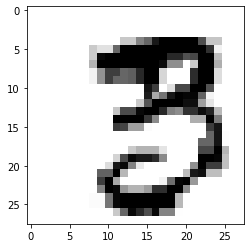

In [24]:
train_data = train.train_data
# train_data = train.transform(train_data)


print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

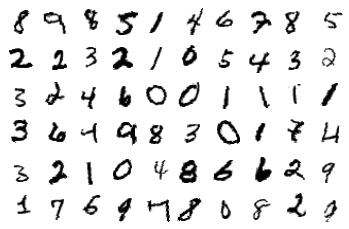

In [25]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
      plt.subplot(6, 10, index)
      plt.axis('off')
      plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss=0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Epoch{epoch} : Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_loss = epoch_loss / len(train_loader.dataset)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss,train_acc


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc=100. * correct / len(test_loader.dataset)
    return test_loss,test_acc

In [8]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_values = []
test_loss_values = []
train_accuracy=[]
test_accuracy=[]

scheduler = OneCycleLR(optimizer, max_lr=0.02,epochs=15,steps_per_epoch=len(train_loader))

for epoch in range(1, 16):
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

    # scheduler.step()

Epoch1 : Loss=0.38076066970825195 Batch_id=468 Accuracy=66.15: 100%|██████████| 469/469 [00:30<00:00, 15.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.1758, Accuracy: 9541/10000 (95.41%)



Epoch2 : Loss=0.09452924132347107 Batch_id=468 Accuracy=92.45: 100%|██████████| 469/469 [00:29<00:00, 15.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0560, Accuracy: 9824/10000 (98.24%)



Epoch3 : Loss=0.10191512852907181 Batch_id=468 Accuracy=95.02: 100%|██████████| 469/469 [00:29<00:00, 15.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0446, Accuracy: 9858/10000 (98.58%)



Epoch4 : Loss=0.044212017208337784 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:29<00:00, 15.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0339, Accuracy: 9891/10000 (98.91%)



Epoch5 : Loss=0.04182327911257744 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:30<00:00, 15.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0288, Accuracy: 9914/10000 (99.14%)



Epoch6 : Loss=0.05302330479025841 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0347, Accuracy: 9889/10000 (98.89%)



Epoch7 : Loss=0.05040441453456879 Batch_id=468 Accuracy=96.94: 100%|██████████| 469/469 [00:29<00:00, 15.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0251, Accuracy: 9922/10000 (99.22%)



Epoch8 : Loss=0.11996984481811523 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:29<00:00, 15.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0249, Accuracy: 9915/10000 (99.15%)



Epoch9 : Loss=0.1280514895915985 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:30<00:00, 15.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0262, Accuracy: 9925/10000 (99.25%)



Epoch10 : Loss=0.04429526999592781 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:30<00:00, 15.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0209, Accuracy: 9933/10000 (99.33%)



Epoch11 : Loss=0.05107252299785614 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:30<00:00, 15.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0243, Accuracy: 9929/10000 (99.29%)



Epoch12 : Loss=0.07672356814146042 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:30<00:00, 15.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0186, Accuracy: 9945/10000 (99.45%)



Epoch13 : Loss=0.10789933800697327 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:29<00:00, 15.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)



Epoch14 : Loss=0.06660258769989014 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:29<00:00, 15.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0174, Accuracy: 9945/10000 (99.45%)



Epoch15 : Loss=0.03042735904455185 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:29<00:00, 15.78it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)



## Incorrect Predictions

In [9]:
def print_wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])   

  return list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))

In [10]:
wrong_predictions = print_wrong_predictions(test_loader,model,device)

In [11]:
print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 56


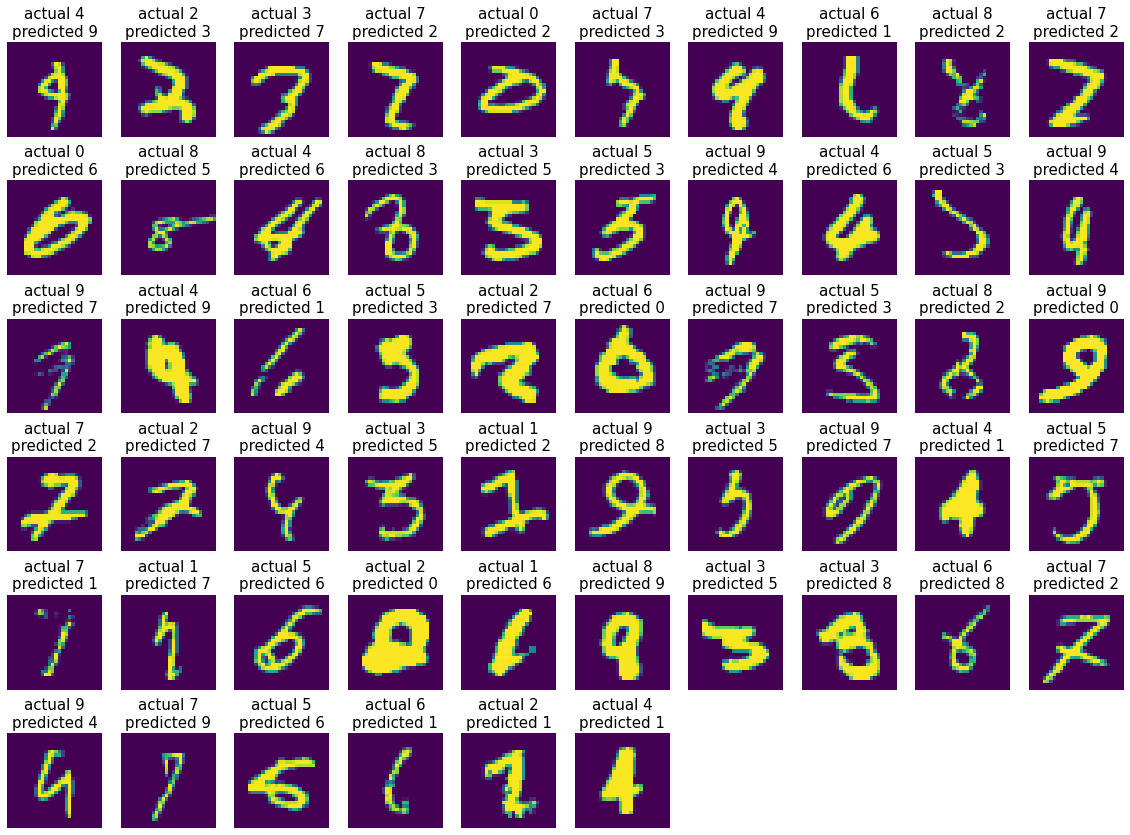

In [12]:
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(wrong_predictions):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()